# Training workflow

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
import os
import copy

from IPython.display import Video

## Constants

In [2]:
CUDA = torch.cuda.is_available()
RANDOM_SEED = 1
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15

print(f"CUDA: {CUDA}")

CUDA: True


In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Load Data

Extracted features, scores, metadata, etc.

In [4]:
data = pd.read_csv("training_set/scores_v2.csv").set_index("video_id")

In [5]:
Video(data.iloc[-1]["video_url"])

In [6]:
def load_C3D_features(video_ids, path = "training_set/Features/C3D"):
    features = []
    for video_id in video_ids:
        filename = f"{path}/{f'{video_id}'.zfill(5)}.mp4.csv"
        features.append(np.loadtxt(filename, delimiter=","))
    return features

In [7]:
def load_ResNet152_features(video_ids, path = "training_set/Features/ResNet152"):
    features = {video_id : [] for video_id in video_ids}
    for filename in os.listdir(path):
        features[int(filename[:5])].append(np.loadtxt(f"{path}/{filename}"))
    return [np.array(features[video_id])[0] for video_id in video_ids]

In [8]:
def load_VGGish_features(video_ids, path = "training_set/Features/VGGish"):
    features = {video_id: [] for video_id in video_ids}
    for filename in os.listdir(path):
        features[int(filename[:-4])].append(np.loadtxt(f"{path}/{filename}"))
    return [np.array(features[video_id])[0] for video_id in video_ids]

In [ ]:
data["c3d"] = load_C3D_features(data.index)

In [ ]:
data["resnet152"] = load_ResNet152_features(data.index)

In [9]:
data["vggish"] = load_VGGish_features(data.index)

## Target Prep

Khosla points out that the memorability score used in Isola's paper did not take into account the memory retention duration.
Cohendet utilized the same idea as Khosla, which involved a decay rate

$$\alpha \leftarrow 
\frac{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1} \log(\frac{t^{(i)}_j}{T})[x^{(i)}_j - m^{(i)}_T] }
{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[ \log(\frac{t^{(i)}_j}{T})]^2}
$$

to calculate memorability 
$$
m_T^{(i)} \leftarrow
\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[x^{(i)}_j - \alpha \log(\frac{t_j^{(i)}}{T})]
$$

where we have $n^{(i)}$ observations for image $i$ given by $x^{(i)} \in {0,1}$ and $t^{(i)}_j$ where $x_j=1$  implies that the image repeat was correctly detected when it shown after time $t_j$

IDEA: potentially explore calculating $\alpha$ per user

In [10]:
st_annotations = pd.read_csv("training_set/short_term_annotations_v2.csv")

In [11]:
st_annotations["t"] = st_annotations["video_position_second"] - st_annotations["video_position_first"]
st_annotations.head()

,video_id,url_name,user_id,rt,key_press,video_position_first,video_position_second,correct,t
0,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,940,905,32,55,140,1,85
1,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,672,1278,32,18,85,1,67
2,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,732,2104,32,76,130,1,54
3,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,722,1344,32,49,95,1,46
4,8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,621,-1,-1,8,91,0,83


In [12]:
print("Average t:", np.mean(st_annotations["t"]))

Average t: 74.96191840735993


In [13]:
# We use approximately the average_t to calculate T as the memorability in question
big_t = 75

In [14]:
def calculate_alpha(annotations, m_T, T = 75):
    numerator = 0
    denominator = 0
    for video_id, video in annotations.groupby("video_id"):
        t = video["t"].to_numpy()
        x = video["correct"].to_numpy()
        n = len(video)
        m = m_T[video_id]
        for j in range(n):
            numerator += (np.log(t[j] / T) * (x[j] - m)) / n
            denominator += (np.log(t[j] / T) ** 2) / n

    return numerator / denominator

In [15]:
def calculate_memorability(annotations, alpha, T = 75):
    m_T = {}
    for video_id, video in annotations.groupby("video_id"):
        t = video["t"].to_numpy()
        x = video["correct"].to_numpy()
        n = len(video)
        m = 0
        for j in range(n):
            m += x[j] - (alpha * np.log(t[j] / T))
        m_T[video_id] = m / n
    return m_T

In [16]:
num_iterations = 10

m_T = {video_id: 1 for video_id in st_annotations["video_id"]}
for iteration in range(num_iterations):
    alpha = calculate_alpha(st_annotations, m_T, T = big_t)
    m_T = calculate_memorability(st_annotations, alpha, T = big_t)
print(alpha)

-0.026433626378523905


In [17]:
data[f"m_{big_t}"] = pd.Series(m_T)

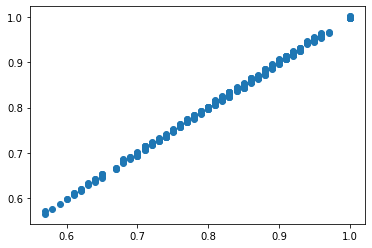

In [18]:
plt.scatter(data["part_1_scores"], data[f"m_{big_t}"])
plt.show()

## Data Prep

Building datasets

potentially weighting samples based on annotations?



In [19]:
data.head()

,video_url,ann_1,ann_2,part_1_scores,part_2_scores,vggish,m_75
video_id,,,,,,,
8,https://mtc.cdn.vine.co/r/videos_h264high/9EB0...,20,7,0.75,0.57,"[[-1.006786823272705, -0.03442689776420593, 0....",0.747473
26,https://mtc.cdn.vine.co/r/videos_h264high/A8B3...,23,7,0.87,0.43,"[[-0.353262335062027, 0.17087110877037048, 0.1...",0.867012
33,https://mtc.cdn.vine.co/r/videos/267829AEFA128...,26,4,0.69,0.75,"[[-0.25408658385276794, 0.027170300483703613, ...",0.687874
46,https://mtc.cdn.vine.co/r/videos_h264high/B974...,23,7,0.87,0.57,"[[-0.6350699663162231, -0.5598430633544922, 1....",0.867301
64,https://mtc.cdn.vine.co/r/videos_h264high/C4D6...,19,9,0.84,0.56,"[[-0.20317420363426208, 0.007105976343154907, ...",0.841082


In [20]:
def split_training(data: pd.DataFrame, shuffle=True, split=0.8):
    ids = np.random.permutation(list(data.index)) if shuffle else list(data.index)
    split_index = int(len(ids) * split)
    return data.loc[ids[:split_index]], data.loc[ids[split_index:]]

In [21]:
train, valid = split_training(data)
print("training:",len(train))
print("validation:", len(valid))

training: 472
validation: 118


In [22]:
def build_matrixes(data, target_name, feature_name, dtype=np.float32):
    targets = []
    features = []
    video_ids = []
    for video_id, row in data.iterrows():
        feature = np.array(row[feature_name])
        target = row[target_name]
        if len(feature.shape) == 1:
            targets.append(target)
            video_ids.append(video_id)
            features.append(feature)
        elif len(feature.shape) == 2:
            for embedding in feature:
                targets.append(target)
                video_ids.append(video_id)
                features.append(embedding)
        else:
            raise RuntimeError(f"Provided feature has unexpected number of dimensions: {len(feature.shape)}")
    target_matrix = np.array(targets, dtype=dtype).reshape((len(targets), 1))
    feature_matrix = np.array(features, dtype=dtype)
    return feature_matrix, target_matrix, video_ids

#### Pick Features and Target

In [23]:
target = "m_75"
features = "vggish"

In [25]:
features_train, targets_train, video_ids_train = build_matrixes(train, target_name = target, feature_name = features)
features_valid, targets_valid, video_ids_valid = build_matrixes(valid, target_name = target, feature_name = features)

print("features_train shape:", features_train.shape)
print("targets_train shape:", targets_train.shape)
print("features_valid shape:", features_valid.shape)
print("features_valid shape:", targets_valid.shape)

features_train shape: (2637, 128)
targets_train shape: (2637, 1)
features_valid shape: (647, 128)
features_valid shape: (647, 1)


In [ ]:
# Using Neural network

class FlatDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [ ]:
# Using Neural network

data_train = FlatDataset(features_train, targets_train)
data_valid = FlatDataset(features_valid, targets_valid)
print(len(data_train), len(data_valid))

## Model setup

In [ ]:
# Using Neural network

input_dim = len(features_train[0])
output_dim = 1 if len(targets_train.shape) == 1 else len(targets_train[0])
print("input dimensions:", input_dim)
print("output dimension:", output_dim)

In [ ]:
# Using Neural network

class TwoLayerNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = 256):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x
        

In [ ]:
# Using Neural network

model = TwoLayerNet(input_dim, output_dim)

In [26]:
# Using SVR

from sklearn.svm import SVR

model = SVR(kernel='rbf', C=0.1, epsilon=0.001, gamma='scale')

## Training setup

In [ ]:
# Using Neural network

device = torch.device("cuda") if CUDA else torch.device("cpu")
model = model.float().to(device)
num_epochs = NUM_EPOCHS
batch_size = BATCH_SIZE
learning_rate = LEARNING_RATE
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma = 0.5)
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(data_valid, batch_size=1)

## Train model

In [27]:
# Using SVR
model.fit(features_train, targets_train.ravel())

SVR(C=0.1, epsilon=0.001)

In [ ]:
# Using Neural network

def train(model, dataloader_train, dataloader_valid, loss_fn, optimizer, scheduler, device):
    
    for is_training in [True, False]: # Epoch is a training followed by validation 
        
        model.train() if is_training else model.eval()
        
        running_loss = 0
        for features, targets in (dataloader_train if is_training else dataloader_valid):
            features = features.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(is_training):
                outputs = model(features)
                loss = loss_fn(outputs, targets)
                if is_training:
                    loss.backward()
                    optimizer.step()           
            running_loss += loss.item()
        
        if is_training:
            scheduler.step()
        
        if is_training:
            train_loss = running_loss
        else:
            valid_loss = running_loss
    
    return train_loss, valid_loss

In [ ]:
# Using Neural network

best_valid_loss = 9999999
best_model_state_dict = copy.deepcopy(model.state_dict())

In [ ]:
# Using Neural network

train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    print(f"--------------- Epoch {epoch} ----------------")
    train_loss, valid_loss = train(model = model,
                                 dataloader_train = dataloader_train,
                                 dataloader_valid = dataloader_valid,
                                 loss_fn = loss_fn,
                                 optimizer = optimizer,
                                 scheduler = scheduler,
                                 device = device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_state_dict = copy.deepcopy(model.state_dict())
        print("New Best Validiation Loss!!!", valid_loss)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print("Training Loss:", train_loss)
    print("Validation Loss:", valid_loss)
    
print("\n\nFINISHED TRAINING")
print(f"Best validation lost: {best_valid_loss}")

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
best_model = model
best_model = best_model.eval()
best_model.load_state_dict(best_model_state_dict)

## Test

Spearman's rank correlation, ROC curves, etc

In [28]:
# Using SVR

predictions = model.predict(features_valid)
actuals = targets_valid.ravel()


In [ ]:
# Using neural network

predictions = []
actuals = []
for feature, actual in dataloader_valid:
    with torch.set_grad_enabled(False):
        feature = feature.to(device)
        output = best_model(feature)
        predictions.append(output.cpu().numpy()[0])
        actuals.append(actual.cpu().numpy()[0])

In [30]:
def average_predictions(predictions, actuals, video_ids):
    predictions_per_video = {vid: [] for vid in np.unique(video_ids)} 
    actuals_per_video = {vid: [] for vid in np.unique(video_ids_valid)} 
    for prediction, actual, video_id in zip(predictions, actuals, video_ids):
        predictions_per_video[video_id].append(prediction)
        actuals_per_video[video_id].append(actual)
    avg_predictions = []
    avg_actuals = []
    for vid in np.unique(video_ids):
        avg_predictions.append(np.mean(predictions_per_video[vid]))
        avg_actuals.append(np.mean(actuals_per_video[vid]))
    return avg_predictions, avg_actuals

In [31]:
predictions, actuals = average_predictions(predictions, actuals, video_ids_valid)

In [32]:
len(predictions)

118

In [33]:
spearman_rank, _ = stats.spearmanr(actuals, predictions)
print(spearman_rank)

0.10245819318600974


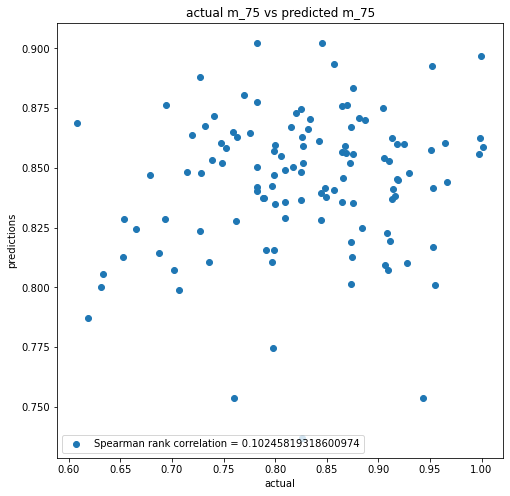

In [34]:
fig, ax = plt.subplots(1, figsize=(8,8))
plt.scatter(actuals, predictions, label = f"Spearman rank correlation = {spearman_rank}")
plt.title(f"actual {target} vs predicted {target}")
plt.legend()
plt.ylabel("predictions")
plt.xlabel("actual")
plt.show()

# Saving model to file

In [ ]:
modelname = "resnet152_0"

In [ ]:
if not os.path.exists(f"saved_models/{modelname}"):
    os.mkdir(f"saved_models/{modelname}")

if not np.sum([spearman_rank < float(f"0.{s.split('.')[0]}") for s in os.listdir(f"saved_models/{modelname}")]):
    try:
        filename = f"saved_models/{modelname}/{int(str(spearman_rank)[2:6])}.state_dict"
        torch.save(best_model.state_dict(), filename)
        print(f"Model saved as {filename}")
    except:
        print("Invalid spearman rank")

In [ ]:
data